# View Histogram Data Of Car and Non-Car image to understand HOG better

In [1]:
import cv2 as cv

In [2]:
def concatPathAndFilename(path, filename):
    return path + "/" + filename

In [3]:
vehicle = "CarTrainingData/vehicles/KITTI_extracted"
non_vehicle = "CarTrainingData/non-vehicles/GTI"

vehicle_img = cv.imread(concatPathAndFilename(vehicle, "1.png"))
grey_vehicle_img = cv.cvtColor(vehicle_img, cv.COLOR_BGR2GRAY)
non_vehicle = cv.imread(concatPathAndFilename(non_vehicle, "image5.png"))
grey_non_vehicle = cv.cvtColor(non_vehicle, cv.COLOR_BGR2GRAY)

In [4]:
img_size = vehicle_img.shape[:2]
img_size  # H x W

(64, 64)

In [5]:
from skimage.feature import hog

hog_desc, hog_image = hog(
    vehicle_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=-1,
)
hog_desc_nv, hog_image_nv = hog(
    non_vehicle,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    channel_axis=-1,
)

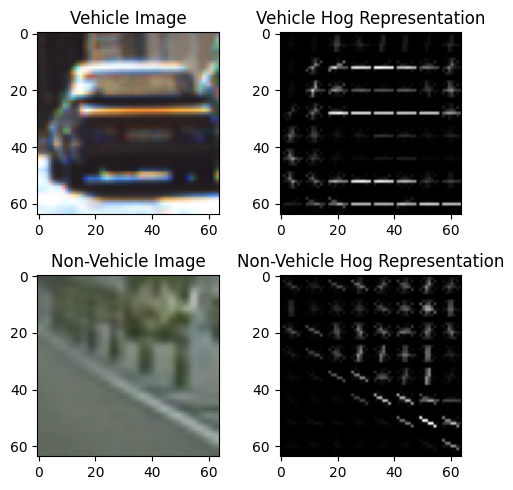

In [6]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
axis[0, 0].imshow(vehicle_img)
axis[0, 0].set_title("Vehicle Image")
axis[0, 1].imshow(hog_image, cmap="grey")
axis[0, 1].set_title("Vehicle Hog Representation")
axis[1, 0].imshow(non_vehicle)
axis[1, 0].set_title("Non-Vehicle Image")
axis[1, 1].imshow(hog_image_nv, cmap="grey")
axis[1, 1].set_title("Non-Vehicle Hog Representation")
plt.tight_layout()
plt.show()

In [7]:
print(hog_desc.shape)
print(hog_desc_nv.shape)

(1764,)
(1764,)


# Get an SVM classifer trained on all the vehicle and non-vehicle training data.

In [8]:
import os
import numpy as np


def getHogFeatures(images):
    features = []
    for im in images:
        hog_desc = hog(
            im,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False,
            channel_axis=-1,
        )
        features.append(hog_desc)
    return features

In [9]:
def getAllImagesInDirectory(dir):
    return [
        cv.imread(os.path.join(root_dir, file))
        for root_dir, _, files in os.walk(dir)
        for file in files
        if file.endswith((".jpg", ".png"))
    ]

In [10]:
vehicle_images = getAllImagesInDirectory("CarTrainingData/vehicles")
non_vehicle_images = getAllImagesInDirectory("CarTrainingData/non-vehicles")
print(np.array(vehicle_images).shape)
print(np.array(non_vehicle_images).shape)

(8792, 64, 64, 3)
(8968, 64, 64, 3)


In [11]:
# Augment Images
def randomAugmenting(images):
    for i, image in enumerate(images):
        angle = np.random.uniform(-45, 45)
        h, w = image.shape[:2]
        center = (w // 2, h // 2)

        scale_factor = np.random.uniform(0.50, 1.50)

        # Get rotation matrix
        rotation_matrix = cv.getRotationMatrix2D(center, angle, scale=scale_factor)

        # Rotate image, adjust the border mode as needed
        rotated_image = cv.warpAffine(image, rotation_matrix, (w, h))
        images[i] = rotated_image
    return images

In [12]:
vehicle_images = randomAugmenting(vehicle_images)
non_vehicle_images = randomAugmenting(non_vehicle_images)

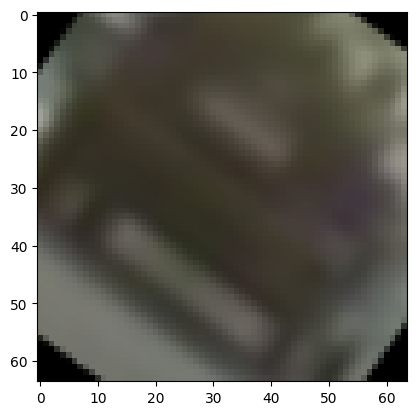

In [13]:
plt.imshow(vehicle_images[0])
plt.show()

In [14]:
positive_features = getHogFeatures(vehicle_images)
negative_features = getHogFeatures(non_vehicle_images)
print(np.array(positive_features).shape)
print(np.array(negative_features).shape)

(8792, 1764)
(8968, 1764)


In [15]:
positive_labels = np.ones(len(positive_features))
negative_labels = np.zeros(len(negative_features))

In [16]:
all_features = np.array(positive_features + negative_features)
all_labels = np.concatenate((positive_labels, negative_labels))

In [17]:
print(all_features.shape)
print(all_labels.shape)

(17760, 1764)
(17760,)


In [18]:
# Split my data into train, test and verification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.2, random_state=9
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=9
)

In [19]:
# train model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Find best parameters
param_grid = {"C": [10], "kernel": ["poly", "rbf"]}
grid_search = GridSearchCV(
    SVC(probability=True), param_grid, cv=5, verbose=2
)  # cv=5 for 5-fold cross-validation
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ..................................C=10, kernel=poly; total time=  51.3s
[CV] END ..................................C=10, kernel=poly; total time=  51.3s
[CV] END ..................................C=10, kernel=poly; total time=  50.2s
[CV] END ..................................C=10, kernel=poly; total time=  50.1s
[CV] END ..................................C=10, kernel=poly; total time=  50.8s
[CV] END ...................................C=10, kernel=rbf; total time= 1.3min
[CV] END ...................................C=10, kernel=rbf; total time= 1.3min
[CV] END ...................................C=10, kernel=rbf; total time= 1.3min
[CV] END ...................................C=10, kernel=rbf; total time= 1.3min
[CV] END ...................................C=10, kernel=rbf; total time= 1.3min
{'C': 10, 'kernel': 'rbf'}


In [20]:
# Test Functionality Of Model
from sklearn.metrics import accuracy_score, classification_report  # Add more as needed

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.9504504504504504
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      1806
         1.0       0.96      0.94      0.95      1746

    accuracy                           0.95      3552
   macro avg       0.95      0.95      0.95      3552
weighted avg       0.95      0.95      0.95      3552



In [21]:
# Test Functionality With Validation Data (Check Overfitting)
from sklearn.metrics import accuracy_score, classification_report  # Add more as needed

y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.9518581081081081
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1759
         1.0       0.96      0.94      0.95      1793

    accuracy                           0.95      3552
   macro avg       0.95      0.95      0.95      3552
weighted avg       0.95      0.95      0.95      3552



In [22]:
# Save model
import pickle

# Save the model
with open("car_detect_svm.pkl", "wb") as f:
    pickle.dump(best_model, f)

## Model is has an accuracy of 99% at detecting a car. Now time to move to applying this using the sliding window to find where on the image a car is

In [36]:
def slidingWindows(image, window_size=(64, 64), step_size=16):
    img_w = image.shape[1]
    img_h = image.shape[0]
    window_w = window_size[0]
    window_h = window_size[1]
    # Loop through the image starting from the top left and go to the bottom right
    for y in range(2 * img_h // 5, img_h - window_h + 1, step_size):
        if y + window_h >= img_h:
            break
        for x in range(0, img_w - window_w + 1, step_size):
            # Now we are looking at the window where the top left pixel is at x and y.
            # The window will go to the right window_w and will go down window_h.
            # recording the window with yield
            if x + window_w >= img_w:
                break
            yield (x, y, x + window_w, y + window_h)

(720, 1280, 3)
(64, 64, 3)
(1, 1764)


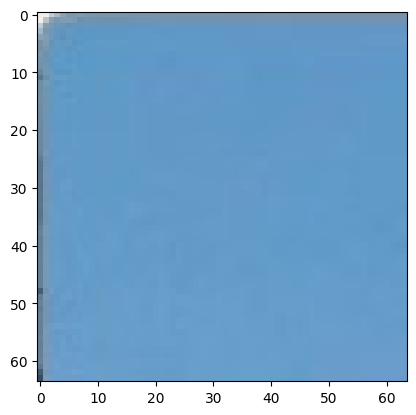

In [37]:
test2 = cv.imread("CarTrainingData/testImages/test1.jpg")
print(test2.shape)
test2 = cv.cvtColor(test2, cv.COLOR_BGR2RGB)
test2 = test2[0:64, 0:64, :]
print(test2.shape)
window_hog_features = np.array(getHogFeatures([test2]))
print(window_hog_features.shape)
plt.imshow(test2[0:64, 0:64, :])
plt.show()

0.9749503118149905
0.9919497244473298
0.969975833874377
0.9657898446223921
0.9885843074203727
0.9972888637112773
0.9543094930344677
0.981646030338522
0.9827394707533506
0.9783410291994927
0.9966500328551465
0.9654648559747275


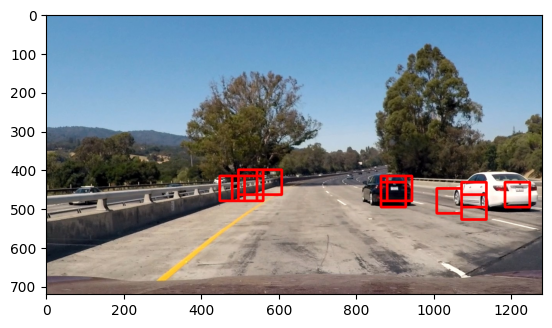

In [38]:
import pickle

# Later, load the model
with open("car_detect_svm.pkl", "rb") as f:
    loaded_svm = pickle.load(f)

# test on image without image pyramid

test1 = cv.imread("CarTrainingData/testImages/test1.jpg")
drawImg = test1.copy()

for x, y, winx, winy in slidingWindows(test1):
    window = test1[y:winy, x:winx, :]
    if window.shape != (64, 64, 3):
        continue
    window_hog_features = getHogFeatures([window])
    if (
        loaded_svm.predict(window_hog_features) == 1
        and loaded_svm.predict_proba(window_hog_features)[0][1] >= 0.95
    ):
        print(loaded_svm.predict_proba(window_hog_features)[0][1])
        drawImg = cv.rectangle(
            drawImg, (x, y), (winx, winy), color=(0, 0, 255), thickness=5
        )
drawImg = cv.cvtColor(drawImg, cv.COLOR_BGR2RGB)

plt.imshow(drawImg)
plt.show()

In [39]:
def overlapping(detections):
    completed_detections = np.zeros(len(detections))
    for i, box in enumerate(detections):
        if completed_detections[i] == 1:
            continue
        completed_detections[i] = 1
        min_x = box[0]
        min_y = box[1]
        max_x = box[2]
        max_y = box[3]
        for j in range(i + 1, len(detections)):
            if completed_detections[j] == 1:
                continue
            j_box = detections[j]
            # Check if left X overlaps
            min_x_overlap = min_x <= j_box[0] and max_x >= j_box[0]
            # Check if right X overlaps
            max_x_overlap = min_x <= j_box[2] and max_x >= j_box[2]
            # Check if top Y overlaps
            min_y_overlap = min_y <= j_box[1] and max_y >= j_box[1]
            # Check if bottom Y overlaps
            max_y_overlap = min_y <= j_box[3] and max_y >= j_box[3]

            if (min_x_overlap or max_x_overlap) and (min_y_overlap or max_y_overlap):
                # Box overlap adjust X values and mark box as completed
                min_x = min(min_x, j_box[0])
                min_y = min(min_y, j_box[1])
                max_x = max(max_x, j_box[2])
                max_y = max(max_y, j_box[3])
                completed_detections[j] = 1
        # Record new expanded box
        yield (min_x, min_y, max_x, max_y)

Image [0] Completed
Image [1] Completed
Image [2] Completed
Image [3] Completed
Image [4] Completed
Image [5] Completed


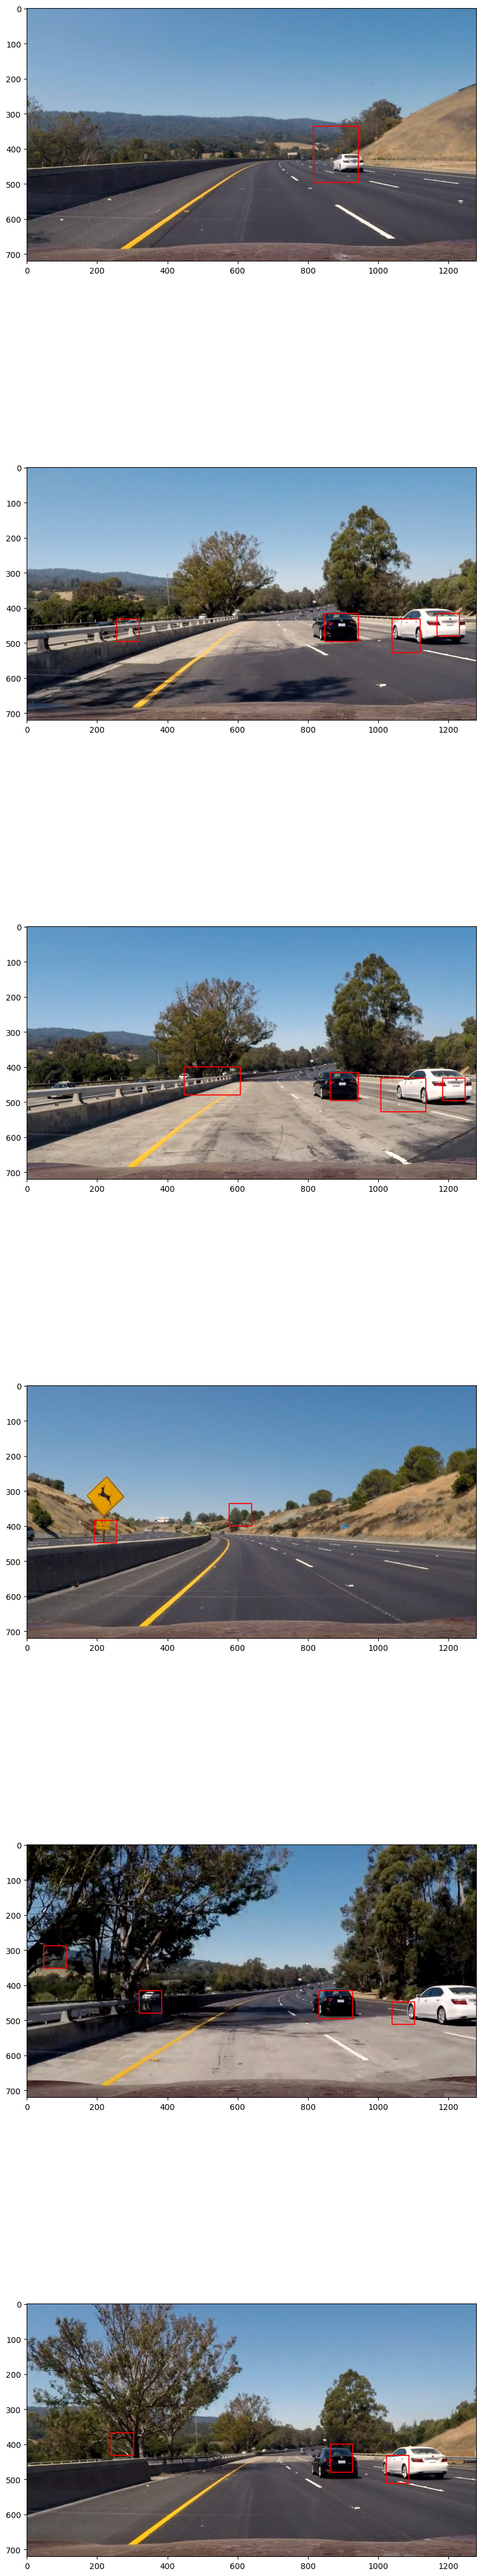

In [40]:
# Need to make image pyramid to provide images at different scales
# scale down
import pickle
import numpy as np

# Later, load the model
with open("car_detect_svm.pkl", "rb") as f:
    loaded_svm = pickle.load(f)

# test on image without image pyramid
test_images = []
test_images = getAllImagesInDirectory("CarTrainingData/testImages")
_, axis = plt.subplots(
    nrows=len(test_images), ncols=1, figsize=(10, len(test_images) * 10)
)
for i, test_img in enumerate(test_images):
    result_img = test_img.copy()
    num_levels = 5
    detections = []
    for scale in range(1, num_levels + 1):
        resized_img = cv.resize(test_img, None, fx=1 / scale, fy=1 / scale)
        for x, y, winx, winy in slidingWindows(resized_img):
            window = test_img[y:winy, x:winx, :]
            if window.shape != (64, 64, 3):
                continue
            window_hog_features = getHogFeatures([window])
            if (
                loaded_svm.predict(window_hog_features) == 1
                and loaded_svm.predict_proba(window_hog_features)[0][1] >= 0.95
            ):
                scaling_factor = 2 ** (scale - 1)
                adjusted_x = x * scaling_factor
                adjusted_y = y * scaling_factor
                adjusted_width = winx * scaling_factor
                adjusted_height = winy * scaling_factor
                if (
                    max(adjusted_x, resized_img.shape[1], adjusted_width)
                    <= resized_img.shape[1]
                ) and (
                    max(adjusted_y, resized_img.shape[0], adjusted_height)
                    <= resized_img.shape[0]
                ):
                    detections.append(
                        (adjusted_x, adjusted_y, adjusted_width, adjusted_height)
                    )

    # for x, y, max_x, max_y in detections:
    #     result_img = cv.rectangle(result_img, (x, y), (max_x, max_y), color=(0,0,255), thickness=2)
    for x, y, max_x, max_y in overlapping(detections):
        result_img = cv.rectangle(
            result_img, (x, y), (max_x, max_y), color=(0, 0, 255), thickness=2
        )
    result_img = cv.cvtColor(result_img, cv.COLOR_BGR2RGB)

    axis[i].imshow(result_img)
    print(f"Image [{i}] Completed")
plt.show()